In [1]:
# Importing matplotlib inline dependency 
%matplotlib inline

In [2]:
# Importing all dependencies including sqlalchemy, python sql toolkit, and object relational mapper
from matplotlib import style
style.use('fivethirtyeight')
#style.use('seaborn')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import extract
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [3]:
# Variable that stores created engine referencing the `hawaii.sqlite` database file from the resources folder
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Variable reflecting an existing database into a new model
Base = automap_base()

# Reflects the tables
Base.prepare(engine, reflect=True)

In [5]:
# Prints all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [6]:
# Inspector variable that stores inspector function to connect to the engine
inspector = inspect(engine)

# Collects the names of the tables within the database
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Selects and display the first 5 rows of the table from engine using 'execute'
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [8]:
# Variables storing the Reflect Database into object relational mapping classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Creates session link from Python to the database
session = Session(engine)

In [10]:
# Variable that stores the last date entry in the data table
lowest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lowest_date)

('2017-08-23',)


In [11]:
# Variable that stores the last 12 months of data being lowest date minus an entire year giving the lowest date from 2016
previous_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(previous_year)

2016-08-23


In [12]:
# query to pull the last year of precipitation data
rain_measurement = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > previous_year).\
    order_by(Measurement.date).all()

In [13]:
# Loads the data from the query into pandas dataframe
rain_measurement_df = pd.DataFrame(rain_measurement)
rain_measurement_dropped_df = rain_measurement_df.dropna(how='any')
rain_measurement_dropped_df.head(10)

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45
7,2016-08-25,0.08
8,2016-08-25,0.08
9,2016-08-25,0.00
10,2016-08-25,0.00


In [14]:
rain_measurement_dropped_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


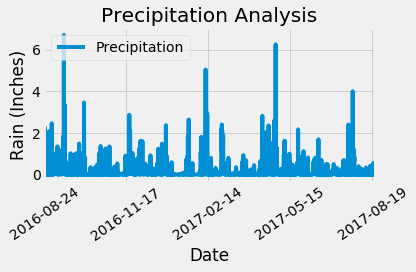

In [15]:
# plot the dataframe
rain_measurement_dropped_df.plot('date', 'prcp')
plt.title("Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.legend(["Precipitation"])
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig("Precipitation_Analysis.png")
plt.show()

In [16]:
# Displaying the summary statistics for the precipitation data
rain_measurement_dropped_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Variable storing total number of stations in the Measurement table then printing results using a format statement
station_total = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(station_total))

There are 9 stations.


In [18]:
# Variable storing the query from the measurement station and grabbing the count of tobs then grouping it by measurement station and finally ordering the count as descending for all values
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                 order_by(func.count(Measurement.tobs).desc()).all()

# Variable storing the most active station (since the list of stations are in descending making the most active one immediatley at the top hence indexing at '[0][0]')
most_active = active_station[0][0]    

# Print statment 
print("Stations and their number of observations in descending order:")

# Print statment for spaceing 
print()

# For loop bringing in the first index value and the second from 'active_station' followed with printing the results in a sentence 
for x, y in active_station:
    print("Station", x,"had", y, "weather observations.")

# Print statement for spacing
print()

# Print statement for displaying the most active station
print("The most active station was",most_active,"counting",active_station[0][1],"observations.")

Stations and their number of observations in descending order:

Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.

The most active station was USC00519281 counting 2772 observations.


In [19]:
# Variable that stores query to pull the previous year of precipitation data for the busiest station to use for histogram
most_active_station_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).filter(Measurement.date > previous_year).order_by(Measurement.date).all()

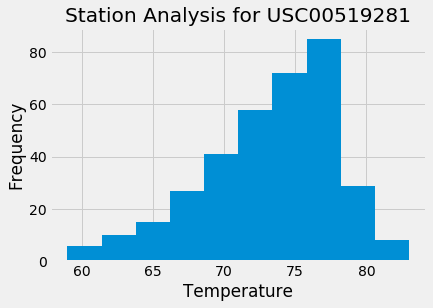

In [20]:
# Histogram plot of the temperature data for the most active station
temperature_df =pd.DataFrame(most_active_station_data)
plt.hist(temperature_df['tobs'])
plt.title("Station Analysis for" + " " + most_active)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Station_Analysis.png")
plt.show()

In [21]:
# Variable that stores a list of the min, max, and average temps
temperature_list = []

# Variable storing the starting date 
start_date='2016-08-01'

# Variable storing the ending date
end_date='2017-08-01'

# Creates a query that will calculate the min, max, and avg for all data in measurement.tobs then labels them a designated name
def calc_temps(start_date, end_date):
    results=session.query(func.min(Measurement.tobs).label("min_tobs"),\
                          func.max(Measurement.tobs).label("max_tobs"),\
                          func.avg(Measurement.tobs).label("avg_tobs")).\
                          filter(Measurement.date.between(start_date , end_date))  

    # Pulling only one result for each min, max, and avg
    result_one = results.one()
    
    # Variables that store the first result of the labeled calculation for min, max, and avg
    TMIN = result_one.min_tobs
    TMAX = result_one.max_tobs
    TAVG= result_one.avg_tobs
    
    # Adds/appends the temperature min, max, and avg to the above temperature list
    temperature_list.append(TMIN)
    temperature_list.append(TMAX)
    temperature_list.append(TAVG)

# Displays the temperature list from between the dates created in start_date and end_date variables   
calc_temps(start_date, end_date)
temperature_list

[58.0, 87.0, 74.64288840262581]

In [22]:
# Variables created to store the position of the min, max, and avg temperatures in the temperature_list
TMIN = temperature_list[0]
TMAX = temperature_list[1]
TAVG = temperature_list[2]

C:\Users\btech\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


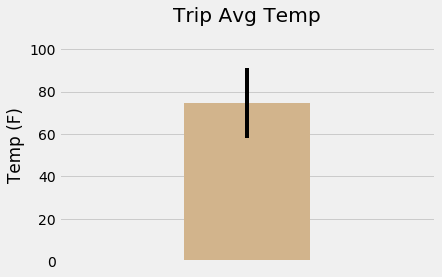

In [23]:
# Bar chart showing the TAVG / Average Temperature from 2016-08-01 to 2017-08-01 with a yerr of TMAX-TMIN (For some reason TAVG-TMIN was giving me the accurate yerror and not TMAX-TMIN...I'm not sure why?) )
# plt.bar(1, TAVG, color = 'tan', yerr = TMAX-TMIN, align='center')
plt.bar(1, TAVG, color = 'tan', yerr = TAVG-TMIN, align='center')
plt.axes().get_xaxis().set_visible(False)
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [24]:
# Variable storing the query for each station in measurment that uses a function to count the precipitation (prcp) then group the counts by station while filtering the data to only display between the date/timeframe 2016-08-01 to 2017-08-01  
station_prcp = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).filter(Measurement.date.between('2016-08-01', '2017-08-01')).all()
station_prcp

[('USC00513117', 365),
 ('USC00514830', 261),
 ('USC00516128', 331),
 ('USC00517948', 67),
 ('USC00519281', 365),
 ('USC00519397', 361),
 ('USC00519523', 320)]

In [25]:
# Variable that is used to store the month number 
month_date = 1

# Variable that is used to store the range for the date '15th' that coincides with the date used previously
day_date = range(1, 16)

# For Loop that queries through the dates in order to extract 01-15 date over the course of 7 years
for date in range(1, 16):
    
    # Variable that stores the query that uses .extract() in order to filter the measurment date equal to the variable "month_date" and the day that is equal to 'date' from the for loop then grouping/ordering by measurement date 
    query_dates = session.query(Measurement.date).filter(extract('month', Measurement.date) == month_date).filter(extract('day', Measurement.date) == date ).group_by(Measurement.date).order_by(Measurement.date).all()

# Displaying the results
query_dates

[('2010-01-15'),
 ('2011-01-15'),
 ('2012-01-15'),
 ('2013-01-15'),
 ('2014-01-15'),
 ('2015-01-15'),
 ('2016-01-15'),
 ('2017-01-15')]

In [26]:
# Variables that store the list of dates, TMIN's, TAVG's, and TMAX's
date_holder = []
TMIN_holder = []
TAVG_holder = []
TMAX_holder =[]

# Variables that store the month number and range for the date '15th' that coincides with the date used previously
month_date = 1
day_date = range(1, 16)

# Creates a query that will label the measurement dates with the date_holder list and calculate the min, avg, and max for all data in measurement.tobs then groups/orderby measurement date
def daily_normals():   
    for x in range(1,16):
        daily_normal_extraction = session.query(Measurement.date.label("date_holder"), 
                              func.min(Measurement.tobs).label("min_tobs"),
                              func.avg(Measurement.tobs).label("avg_tobs"),
                              func.max(Measurement.tobs).label("max_tobs")).\
                              filter(extract('month', Measurement.date) == month_date).\
                              filter(extract('day', Measurement.date) == x ).group_by(Measurement.date).order_by(Measurement.date)
        
        # For loop that stores and prints the results from the variable called daily_normal_extraction into variables called Date, TMAX, TMIN, and TAVG
        for y in daily_normal_extraction.all():            
            Date = y.date_holder
            TMAX = y.max_tobs
            TMIN = y.min_tobs
            TAVG = y.avg_tobs           
            print(y)
        
        # Adds/appends all of the info from the previous for loop into their respective lists/holders
        date_holder.append(Date)
        TMIN_holder.append(TMIN)
        TAVG_holder.append(TAVG)
        TMAX_holder.append(TMAX)

# Displays the results 
daily_normals()

('2010-01-01', 65.0, 69.71428571428571, 75.0)
('2011-01-01', 69.0, 72.14285714285714, 77.0)
('2012-01-01', 63.0, 68.42857142857143, 71.0)
('2013-01-01', 69.0, 70.5, 72.0)
('2014-01-01', 65.0, 68.66666666666667, 75.0)
('2015-01-01', 63.0, 66.28571428571429, 71.0)
('2016-01-01', 62.0, 68.16666666666667, 74.0)
('2017-01-01', 62.0, 69.33333333333333, 74.0)
('2010-01-02', 61.0, 67.0, 75.0)
('2011-01-02', 70.0, 72.0, 74.0)
('2012-01-02', 63.0, 65.8, 71.0)
('2013-01-02', 67.0, 70.0, 73.0)
('2014-01-02', 69.0, 73.625, 77.0)
('2015-01-02', 60.0, 65.0, 72.0)
('2016-01-02', 69.0, 71.83333333333333, 73.0)
('2017-01-02', 66.0, 69.2, 74.0)
('2010-01-03', 67.0, 74.0, 77.0)
('2011-01-03', 69.0, 72.28571428571429, 74.0)
('2012-01-03', 63.0, 65.71428571428571, 70.0)
('2013-01-03', 66.0, 68.28571428571429, 70.0)
('2014-01-03', 65.0, 68.25, 73.0)
('2015-01-03', 62.0, 66.42857142857143, 72.0)
('2016-01-03', 63.0, 68.5, 75.0)
('2017-01-03', 63.0, 67.66666666666667, 73.0)
('2010-01-04', 72.0, 75.0, 76.0)
('2

In [27]:
# Variable that creates a DataFrame with the data for date, tmin, tavg and tmax
daily_df = pd.DataFrame({'Date': date_holder, 
                         'T_min': TMIN_holder,
                         'T_avg': TAVG_holder,
                         'T_max': TMAX_holder})
        
# Setting the index for 'daily_df' to date and then viewing the dataframe
daily_df.set_index('Date', inplace=True)
daily_df.head()

,T_min,T_avg,T_max
Date,,,
2017-01-01,62.0,69.333333,74.0
2017-01-02,66.0,69.200000,74.0
2017-01-03,63.0,67.666667,73.0
2017-01-04,62.0,67.166667,73.0
2017-01-05,63.0,67.500000,72.0


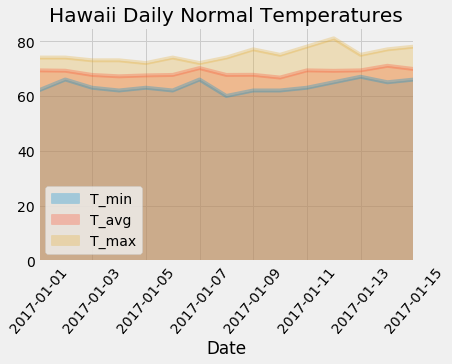

In [28]:
# Plotting the data from 'daily_df' to create an area plot for T_min, T_avg, and T_max
daily_df.plot(kind='area', alpha=.3, stacked=False, title='Hawaii Daily Normal Temperatures')
plt.xticks(rotation = 50)
plt.savefig("Hawaii_Daily_Normal_Temperatures.png")
plt.show()